In [2]:
import pandas as pd

moonshot = pd.read_pickle('moonshot_submissions.p')

In [3]:
minimoonshot = moonshot.drop_duplicates('CID_group')

In [134]:
import enum

class Method(enum.Enum):
    INITIAL = enum.auto()
    OLD = enum.auto()
    MANUAL = enum.auto()
    MANUAL_POSSIBLY = enum.auto()
    DOCKING = enum.auto()
    FEP = enum.auto()
    UNKNOWN = enum.auto()


def classify(row):
    def has_any_term(*terms):
        return any([term in row.words for term in terms])
        
    if has_any_term('missing fragalysis structures',
                    'first batch of fragments so we have a moonshot cid for them',
                    'fragment that was missing an id not a design but a frament',
                   'second batch of submissions of fragments in order to generate moonshot cid',
                   'final set of fragments so we can generate moonshot cid'):
        return Method.INITIAL
    if has_any_term('sars inhibitor'):
        return Method.OLD
    if has_any_term('fep'):
        return Method.FEP
    if has_any_term('dock', 'seesar', 'vina', 'autodock', 'screen', 'drug-hunter', 'search'):
        return Method.DOCKING
    if has_any_term('by-eye', 'merg', 'link', 'coupl'):
        return Method.MANUAL
    if has_any_term('swap', 'racem', 'side product', 'intermediate', 'break',
                    'bioisoster', 'isomer', 'around', 'replace', 'isomer', 'enantiomer',
                    'introduction', 'substitution', 'shifted', 'combo',
                    'expansion', 'made by', 'design', 'idea', 'based', 'pairs',
                    'modification', 'derivative', 'common sense', 'suggested',
                    'similar to', 'analogues', 'easy to make', 'exploration', 'inspir', 'possible'):
        return Method.MANUAL_POSSIBLY
    if len(row.words) > 200:
        return Method.MANUAL_POSSIBLY 
    if row.fragments != 'x0072':
        return Method.MANUAL_POSSIBLY
    return Method.UNKNOWN
    
moonshot['classified_method'] = moonshot.apply(classify, axis=1)    
moonshot['CRYSTALLISED'] = moonshot['Structure ID'] != ''

In [156]:
import operator
import numpy as np
from IPython.display import display

def summarise(df):
    total = df.classified_method.value_counts()
    made = df.loc[moonshot.MADE | df.CRYSTALLISED].classified_method.value_counts()
    ordered = df.loc[moonshot.ORDERED | df.CRYSTALLISED].classified_method.value_counts()
    crystallised = df.loc[df.CRYSTALLISED].classified_method.value_counts()

    summary = pd.DataFrame({'total': total,
                  'ordered': ordered,
                  'made': made,
                  'crystallised': crystallised})\
                .fillna(0).astype(int)\
                .sort_index(key=np.vectorize(operator.attrgetter('value')))
    summary.index = summary.index.to_series().apply(operator.attrgetter('name')).str.lower()
    summary.loc['total']= summary.sum()
    summary['crystal-over-made%'] = summary.crystallised*100 // summary.made
    return summary

summarise(moonshot)

,total,ordered,made,crystallised,crystal-over-made%
initial,99,93,93,49,52
old,44,17,14,4,28
manual,2757,314,226,44,19
manual_possibly,10328,3080,2523,129,5
docking,7566,691,568,76,13
fep,175,100,55,9,16
unknown,28,19,17,0,0
total,20997,4314,3496,311,8


In [177]:
datestamp = moonshot.ORDER_DATE.apply(lambda v: datetime.date.fromisoformat(v) if v else float('nan'))
summarise(moonshot.loc[datestamp < datetime.date.fromisoformat('2020-06-01')])

,total,ordered,made,crystallised,crystal-over-made%
initial,5,5,5,0,0
old,17,17,14,4,28
manual,164,164,102,26,25
manual_possibly,314,314,205,46,22
docking,439,439,349,62,17
fep,1,1,1,1,100
unknown,6,6,5,0,0
total,946,946,681,139,20


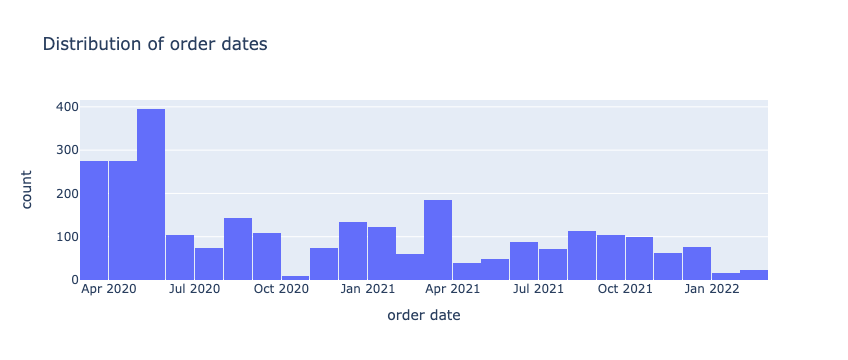

In [174]:
import plotly.express as px
fig = px.histogram(pd.DataFrame({'order date': datestamp.loc[~datestamp.isna()]}),
                   'order date',
                   title='Distribution of order dates')
fig